In [13]:
from sklearn import preprocessing

SETSofVALS = 25
def generateHeader():
    header = []
    for i in range(1,SETSofVALS+1):
        header.append("x"+str(i))
        header.append("y"+str(i))
        header.append("z"+str(i))
        header.append("block"+str(i))
    header.append("biome")
    return header

def encode_columns_dummy(df, header):
    for i in range(1, SETSofVALS+1):
        encode_text_dummy(df,header+str(i))
        
#code below taken from https://github.com/jeffheaton/t81_558_deep_learning
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

    
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   


In [14]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


path = "./Data/"

filename_read = os.path.join(path,"data3.csv")
header = generateHeader()
df = pd.read_csv(filename_read, names=header)

#shuffling - not required as the splitting into train/test does the shuffling for us
#df = df.reindex(np.random.permutation(df.index))
#df.reset_index(inplace=True, drop=True)

biomes = encode_text_index(df,"biome")
encode_columns_dummy(df, "block")
x,y = to_xy(df,"biome")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(50, activation='relu')) # Hidden 2
model.add(Dense(25, activation='relu')) # Hidden 3
model.add(Dense(y.shape[1],activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam')

#early stopping 
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')
#getting best weights 
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

#df

/Users/saadghani/Development/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 00025: early stopping


ValueError: Dimension 0 in both shapes must be equal, but are 699 and 1053. Shapes are [699,100] and [1053,100]. for 'Assign_16' (op: 'Assign') with input shapes: [699,100], [1053,100].

In [8]:
pred = model.predict(x)
print("Shape: {}".format(pred.shape))
print(pred)

predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y,axis=1)
print(f"Predictions: {predict_classes}")
print(f"Expected: {expected_classes}")

from sklearn.metrics import accuracy_score
# Accuracy might be a more easily understood error metric.  It is essentially a test score.  For all of the iris predictions,
# what percent were correct?  The downside is it does not consider how confident the neural network was in each prediction.
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

Shape: (6623, 5)
[[9.3579635e-02 5.6208712e-01 8.3526477e-02 2.2065285e-01 4.0153872e-02]
 [1.8909790e-01 4.5680270e-01 9.5886789e-02 1.9830379e-01 5.9908770e-02]
 [1.6250584e-01 4.7719651e-01 7.9150192e-02 2.1110789e-01 7.0039622e-02]
 ...
 [1.4991342e-08 3.2469892e-08 8.0387962e-12 4.0240611e-06 9.9999595e-01]
 [5.0582376e-04 1.0012657e-03 1.2350746e-03 2.8953964e-03 9.9436247e-01]
 [1.2453434e-10 8.0084739e-08 1.3789548e-08 9.7425027e-07 9.9999893e-01]]
Predictions: [1 1 1 ... 4 4 4]
Expected: [3 3 3 ... 4 4 4]
Accuracy: 0.7531330212894459


Confusion matrix, without normalization
[[393  20   9   1   6]
 [ 36 228  25  37  17]
 [ 31  32 272   0   2]
 [ 26  97   0 130  29]
 [ 10  20   0   9 226]]
Normalized confusion matrix
[[0.92 0.05 0.02 0.   0.01]
 [0.1  0.66 0.07 0.11 0.05]
 [0.09 0.09 0.81 0.   0.01]
 [0.09 0.34 0.   0.46 0.1 ]
 [0.04 0.08 0.   0.03 0.85]]


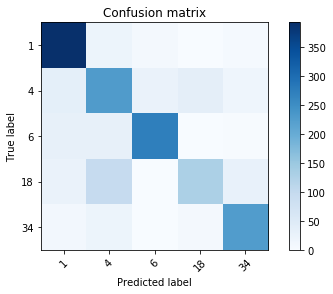

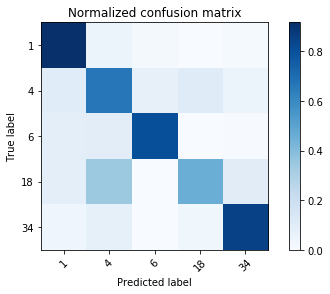

In [11]:
#evaluating data graphically

import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, biomes)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, biomes, title='Normalized confusion matrix')

plt.show()